# VQLS project
Erel Dekel - 326064888 \
Dolev Shmaryahu - 326526258 \
Aviv Gabay - 325880367\
David Swissa - 326046315\
Due - 15.9.24\
[Link to project presentation](https://docs.google.com/presentation/d/17RUi8bnZ1Az26Z5B6WHlXXWPvnvy0RguydNzROxyVuo/edit#slide=id.p)

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import QFT, EfficientSU2
from qiskit.quantum_info import Operator, Statevector

### Important functions

In [102]:
def create_ansatz(num_qubits):
    # Create a quantum circuit for the specified number of qubits
    ansatz = QuantumCircuit(num_qubits)
    params = []
    
    # Add parameterized single-qubit U-gates (θ, φ, λ) to each qubit
    for i in range(num_qubits):
        theta = Parameter(f'θ{i}')
        phi = Parameter(f'φ{i}')
        lambda_ = Parameter(f'λ{i}')
        ansatz.u(theta, phi, lambda_, i)
        params.extend([theta, phi, lambda_])
    
    # Add entanglement layer using controlled-X (CNOT) gates between adjacent qubits
    for i in range(num_qubits - 1):
        ansatz.cx(i, i + 1)
    
    return ansatz, params

def cost_function(params, ansatz, A, b):
    # Bind the parameters to the ansatz circuit
    param_dict = dict(zip(ansatz.parameters, params))
    bound_ansatz = ansatz.assign_parameters(param_dict)
    # Get the state vector after applying the ansatz circuit
    psi = Statevector.from_instruction(bound_ansatz)
    # Compute the cost
    A_psi = psi.evolve(A)
    fidelity = np.abs(np.vdot(b, A_psi.data))**2
    return 1 - fidelity

def optimize_row(ansatz, params, A, b):
    # Randomly initialize parameters for optimization
    initial_params = np.random.uniform(0, 2*np.pi, len(params))
    # Use the COBYLA optimization method to minimize the cost function
    result = minimize(cost_function, initial_params, args=(ansatz, A, b),
                        method='COBYLA', options={'maxiter': 1000})

    # Update the ansatz with optimized parameters and get the resulting state vector
    optimized_circuit = ansatz.assign_parameters(result.x)
    statevector = Statevector.from_instruction(optimized_circuit)
    return statevector.data

def vqls_iqft(num_qubits):
    # Define the Quantum Fourier Transform (QFT) matrix as the problem operator A
    qft = QFT(num_qubits)
    A = Operator(qft)

    # Use an EfficientSU2 ansatz with 2 layers (reps=2) as the variational form
    ansatz = EfficientSU2(num_qubits, reps=2)
    params = ansatz.parameters
    
    # Create an identity matrix to represent basis states |b>
    identity_matrix = np.eye(2**num_qubits, dtype=complex)
    unit_vectors = [identity_matrix[i] for i in range(2**num_qubits)]

    
    iqft_matrix = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)
    # For each basis vector |b>, optimize the ansatz to approximate A|ψ> ≈ |b>
    for i, b in enumerate(unit_vectors):
        iqft_matrix[:, i] = optimize_row(ansatz, params, A, b)

    return iqft_matrix

In [48]:
def phase_correct(matrix):
    # Ensure the first element of each row is positive real
    for i in range(matrix.shape[0]):
        if matrix[0, i].real < 0 or matrix[0, i].imag != 0:
            phase = np.angle(matrix[i, 0])
            matrix[:, i] *= np.exp(-1j * phase)
    return matrix

### Main Code Simulation


Testing for 1 qubits:
VQLS IQFT:
[[ 0.707-0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]
Error for 1 qubit: 5.982169886956245e-06

1 qubits ansatz


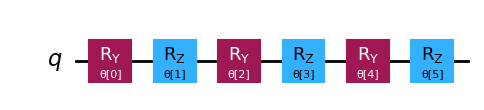

In [98]:
print(f"\nTesting for {1} qubits:")
# Perform Variational Quantum Linear Solver (VQLS) to approximate the Inverse Quantum Fourier Transform (IQFT) for 1 qubit
iqft1_vqls = vqls_iqft(1)
# Correct the phase of the result using the phase_correct function
iqft1_vqls = phase_correct(iqft1_vqls)
iqft1_exact = Operator(QFT(1).inverse()).data

# Display the IQFT matrix obtained using VQLS (rounded to 3 decimal places)
print("VQLS IQFT:")
print(iqft1_vqls.round(3))

# Calculate the error (difference) between the VQLS approximation and the exact IQFT matrix
error1 = np.linalg.norm(iqft1_vqls - iqft1_exact)
print(f"Error for 1 qubit: {error1}\n")

# Display the ansatz
print("1 qubits ansatz")
ansatz = EfficientSU2(1, reps=2)
qc = ansatz.decompose()
qc.draw('mpl')


Testing for 2 qubits:
VQLS IQFT:
[[ 0.5-0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. -0.5j -0.5-0.j  -0. +0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5-0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. +0.5j -0.5-0.j   0. -0.5j]]
Error for 2 qubit: 1.5869076969429057e-05

2 qubits ansatz:


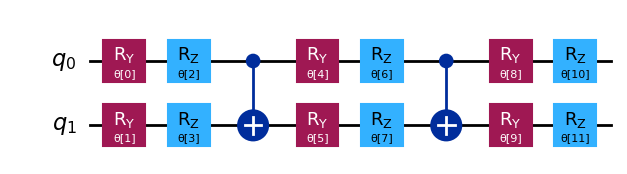

In [99]:
print(f"\nTesting for {2} qubits:")
# Perform Variational Quantum Linear Solver (VQLS) to approximate the Inverse Quantum Fourier Transform (IQFT) for 2 qubit
iqft2_vqls = vqls_iqft(2)
# Correct the phase of the result using the phase_correct function
iqft2_vqls = phase_correct(iqft2_vqls)
iqft2_exact = Operator(QFT(2).inverse()).data

# Display the IQFT matrix obtained using VQLS (rounded to 3 decimal places)
print("VQLS IQFT:")
print(iqft2_vqls.round(3))

# Calculate the error (difference) between the VQLS approximation and the exact IQFT matrix
error2 = np.linalg.norm(iqft2_vqls - iqft2_exact)
print(f"Error for 2 qubit: {error2}\n")

# Display the ansatz
print("2 qubits ansatz:")
ansatz = EfficientSU2(2, reps=2)
qc = ansatz.decompose()
qc.draw('mpl')


Testing for 4 qubits:
VQLS IQFT:
[[ 0.25 +0.j     0.25 +0.j     0.25 -0.j     0.25 +0.j     0.25 +0.j
   0.25 -0.j     0.25 +0.j     0.25 -0.j     0.25 -0.j     0.25 +0.j
   0.25 -0.j     0.25 +0.j     0.25 +0.j     0.25 -0.j     0.25 +0.j
   0.25 -0.j   ]
 [ 0.25 +0.j     0.231-0.096j  0.177-0.177j  0.096-0.231j  0.   -0.25j
  -0.096-0.231j -0.177-0.177j -0.231-0.096j -0.25 -0.j    -0.231+0.096j
  -0.177+0.177j -0.096+0.231j -0.   +0.25j   0.096+0.231j  0.177+0.177j
   0.231+0.096j]
 [ 0.25 +0.j     0.177-0.177j -0.   -0.25j  -0.177-0.177j -0.25 +0.j
  -0.177+0.177j  0.   +0.25j   0.177+0.177j  0.25 -0.j     0.177-0.177j
  -0.   -0.25j  -0.177-0.177j -0.25 +0.j    -0.177+0.177j  0.   +0.25j
   0.177+0.177j]
 [ 0.25 -0.j     0.096-0.231j -0.177-0.177j -0.231+0.096j  0.   +0.25j
   0.231+0.096j  0.177-0.177j -0.096-0.231j -0.25 +0.j    -0.096+0.231j
   0.177+0.177j  0.231-0.096j -0.   -0.25j  -0.231-0.096j -0.177+0.177j
   0.096+0.231j]
 [ 0.25 +0.j     0.   -0.25j  -0.25 -0.j     0.  

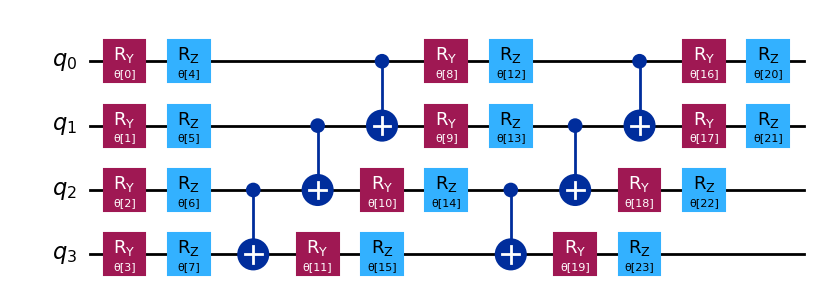

In [100]:
print(f"\nTesting for {4} qubits:")
# Perform Variational Quantum Linear Solver (VQLS) to approximate the Inverse Quantum Fourier Transform (IQFT) for 4 qubit
iqft4_vqls = vqls_iqft(4)
# Correct the phase of the result using the phase_correct function
iqft4_vqls = phase_correct(iqft4_vqls)
iqft4_exact = Operator(QFT(4).inverse()).data

# Display the IQFT matrix obtained using VQLS (rounded to 3 decimal places)
print("VQLS IQFT:")
print(iqft4_vqls.round(3))

# Calculate the error (difference) between the VQLS approximation and the exact IQFT matrix
error4 = np.linalg.norm(iqft4_vqls - iqft4_exact)
print(f"Error for 4 qubit: {error4}\n")

# Display the ansatz
print("4 qubits ansatz")
ansatz = EfficientSU2(4, reps=2)
qc = ansatz.decompose()
qc.draw('mpl')


Testing for 8 qubits:
VQLS IQFT:
[[0.063+0.j    0.062+0.001j 0.063+0.j    ... 0.062+0.001j 0.062+0.j
  0.063+0.j   ]
 [0.063+0.j    0.063-0.001j 0.062-0.003j ... 0.063+0.005j 0.063+0.003j
  0.063+0.002j]
 [0.062+0.j    0.063-0.002j 0.062-0.005j ... 0.062+0.009j 0.062+0.006j
  0.062+0.004j]
 ...
 [0.064-0.j    0.061+0.004j 0.061+0.009j ... 0.059-0.014j 0.06 -0.009j
  0.063-0.005j]
 [0.062+0.j    0.063+0.002j 0.06 +0.005j ... 0.061-0.01j  0.061-0.007j
  0.063-0.002j]
 [0.062+0.j    0.061+0.003j 0.062+0.005j ... 0.063-0.002j 0.064-0.001j
  0.063-0.001j]]
Error for 8 qubit: 0.49837324722178866

8 qubits ansatz


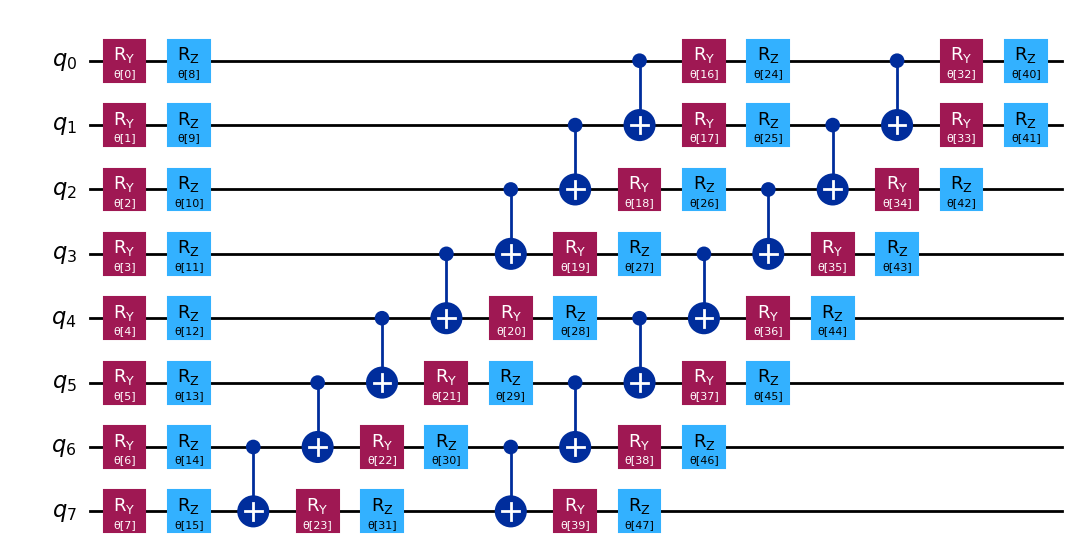

In [103]:
print(f"\nTesting for {8} qubits:")
# Perform Variational Quantum Linear Solver (VQLS) to approximate the Inverse Quantum Fourier Transform (IQFT) for 8 qubit
iqft8_vqls = vqls_iqft(8)
# Correct the phase of the result using the phase_correct function
iqft8_vqls = phase_correct(iqft8_vqls)
iqft8_exact = Operator(QFT(8).inverse()).data

# Display the IQFT matrix obtained using VQLS (rounded to 3 decimal places)
print("VQLS IQFT:")
print(iqft8_vqls.round(3))

# Calculate the error (difference) between the VQLS approximation and the exact IQFT matrix
error8 = np.linalg.norm(iqft8_vqls - iqft8_exact)
print(f"Error for 8 qubit: {error8}\n")

# Display the ansatz
print("8 qubits ansatz")
ansatz = EfficientSU2(8, reps=2)
qc = ansatz.decompose()
qc.draw('mpl')

### Important Plot

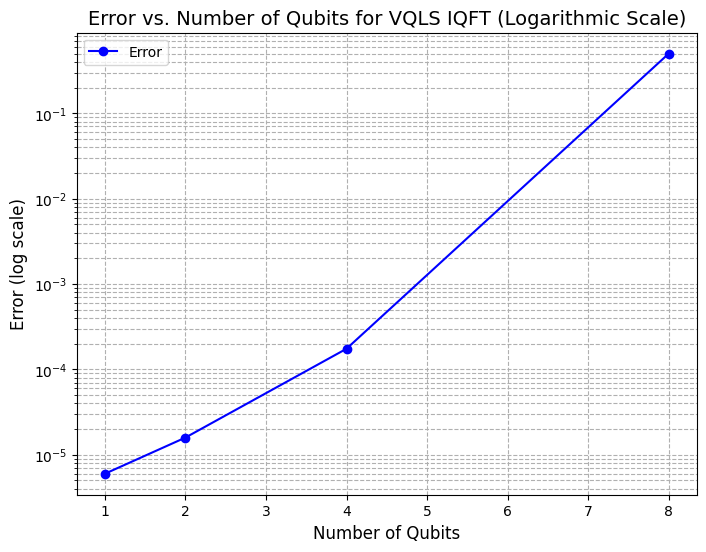

In [4]:
errors = [error1, error2, error4, error8]
qubits = [1, 2, 4, 8]

# Create the plot
plt.figure(figsize=(8, 6))

# Plot error vs. number of qubits with a logarithmic scale on the y-axis
plt.plot(qubits, errors, marker='o', linestyle='-', color='b', label='Error')

# Set logarithmic scale for the y-axis
plt.yscale('log')

# Add labels and title
plt.xlabel('Number of Qubits', fontsize=12)
plt.ylabel('Error (log scale)', fontsize=12)
plt.title('Error vs. Number of Qubits for VQLS IQFT (Logarithmic Scale)', fontsize=14)

# Add grid
plt.grid(True, which="both", ls="--")

# Display the plot
plt.show()